In [1]:
import gcdyn.cycles
from gcdyn.cycles import (
    GC,
    cell_div_balanced_proliferator,
    simple_proliferator,
    binary_proliferator,
)
from IPython.display import display
from Bio import SeqIO

In [2]:
fasta_path = "gcreplay_samples/five_seqs.fasta"
seqs = [
    str(seq_record.seq)
    for seq_record in SeqIO.parse(fasta_path, "fasta")
    if seq_record.id != "naive"
]

Trees with balanced proliferator, uniform mutator, replay selector

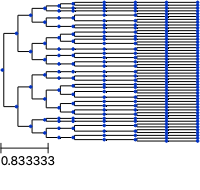

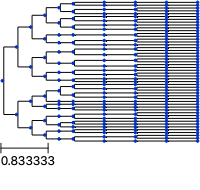

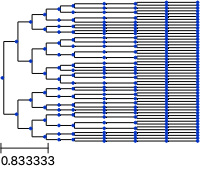

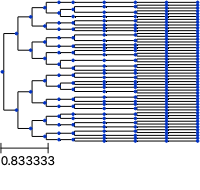

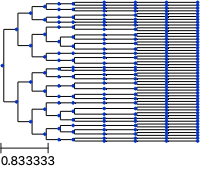

In [3]:
tree_renders = []
replay_cell_div_selector = gcdyn.cycles.DMSSelector(slope=3.37, y_intercept=1)
uniform_mutator = gcdyn.cycles.UniformMutator()

for i in range(len(seqs)):
    seq = seqs[i]
    gc = GC(
        seq,
        cell_div_balanced_proliferator,
        uniform_mutator,
        replay_cell_div_selector,
        N0=1,
        Nmax=50,
    )
    gc.simulate(3, enforce_timescale=True)
    tree_renders.append(gc.tree.render("%%inline", w=200))

for render in tree_renders:
    display(render)

Trees with balanced proliferator, hotspot-aware mutator, replay selector

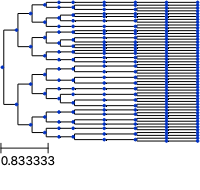

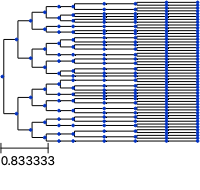

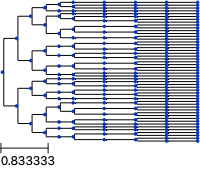

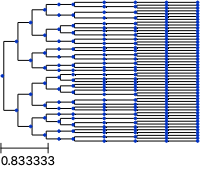

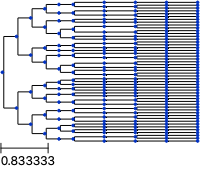

In [4]:
tree_renders = []
replay_cell_div_selector = gcdyn.cycles.DMSSelector(slope=3.37, y_intercept=1)
fivemer_mutator = gcdyn.cycles.FivemerMutator(
    mutability_csv="MK_RS5NF_mutability.csv",
    substitution_csv="MK_RS5NF_substitution.csv",
)
for i in range(len(seqs)):
    seq = seqs[i]
    gc = GC(
        seq,
        cell_div_balanced_proliferator,
        fivemer_mutator,
        replay_cell_div_selector,
        N0=1,
        Nmax=50,
    )
    gc.simulate(3, enforce_timescale=True)
    tree_renders.append(gc.tree.render("%%inline", w=200))

for render in tree_renders:
    display(render)

Trees with balanced proliferator, uniform mutator, uniform selector

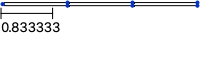

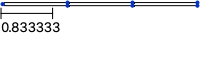

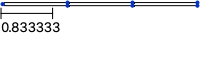

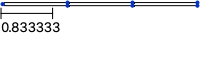

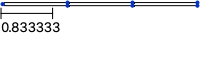

In [5]:
tree_renders = []
uniform_selector = gcdyn.cycles.UniformSelector()
for i in range(len(seqs)):
    seq = seqs[i]
    gc = GC(
        seq,
        cell_div_balanced_proliferator,
        uniform_mutator,
        uniform_selector,
        N0=1,
    )
    gc.simulate(3, enforce_timescale=True)
    tree_renders.append(gc.tree.render("%%inline", w=200))

for render in tree_renders:
    display(render)

Trees with simple proliferator, uniform proliferator, replay selector

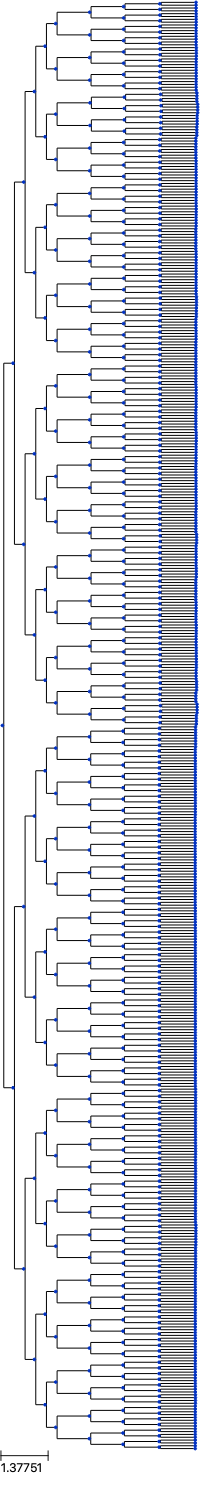

In [6]:
tree_renders = []
for i in range(1):
    seq = seqs[i]
    gc = GC(
        seq,
        simple_proliferator,
        uniform_mutator,
        replay_cell_div_selector,
        N0=1,
    )
    gc.simulate(3, enforce_timescale=False)
    tree_renders.append(gc.tree.render("%%inline", w=200))

for render in tree_renders:
    display(render)

Binary proliferator, uniform mutator, uniform selector

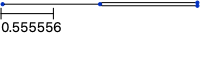

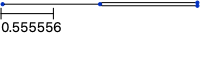

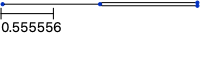

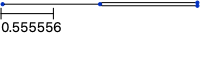

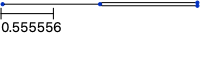

In [7]:
tree_renders = []
for i in range(len(seqs)):
    seq = seqs[i]
    gc = GC(
        seq,
        binary_proliferator,
        uniform_mutator,
        uniform_selector,
        N0=1,
    )
    gc.simulate(3, enforce_timescale=False)
    tree_renders.append(gc.tree.render("%%inline", w=200))

for render in tree_renders:
    display(render)

Look at phenotype trajectory for a simulation of a single cell in a GC

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import seaborn as sns
from matplotlib.colors import SymLogNorm
from ete3 import faces, AttrFace, TreeStyle, NodeStyle, CircleFace


seq = "GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTACATAAGCTACAGTGGTAGCACTTACTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGAATTCTGTGACTACTGAGGACACAGCCACATATTACTGTGGAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAGACATCGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTGTCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCAGCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATTACAGCTATCCTGTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAA"
gc = GC(
    seq,
    cell_div_balanced_proliferator,
    uniform_mutator,
    replay_cell_div_selector,
    N0=1,
    Nmax=35,
)
gc.simulate(3, enforce_timescale=True, prune=False)

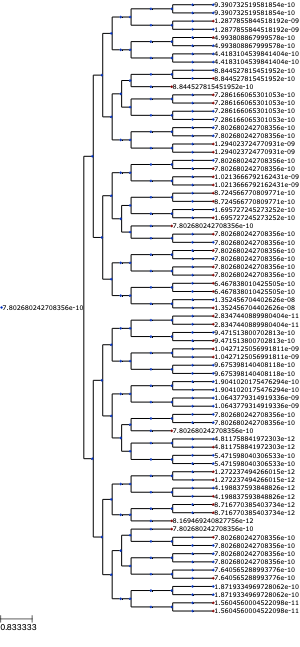

In [9]:
def layout_KD(node):
    if node.is_leaf() or node.is_root():
        faces.add_face_to_node(AttrFace("KD"), node, column=0)
    if node.terminated:
        node.set_style(terminated_style)


terminated_style = NodeStyle()
terminated_style["fgcolor"] = "DarkRed"
ts = TreeStyle()
ts.layout_fn = layout_KD
gc.tree.render("%%inline", w=300, tree_style=ts)

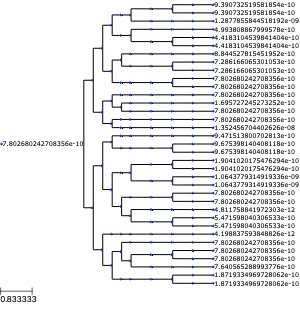

In [10]:
gc.prune()
gc.tree.render("%%inline", w=300, tree_style=ts)

Plotting trajectory of simulated phenotypes in one simulation with three cycles:

/var/folders/qy/y63rpqnw8xn4r6006s6mz6p00000gp/T/ipykernel_7374/2975256716.py:7: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = SymLogNorm(linthresh=1, vmin=0, vmax=10)


Text(0.5, 0, 'distance from starting sequence')

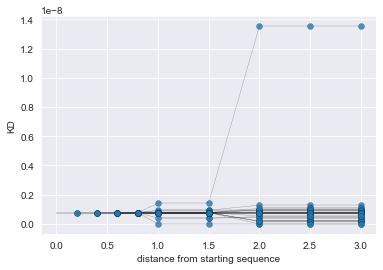

In [11]:
# Adapted from phenotype-trajectories notebook (https://github.com/matsengrp/gcreplay/blob/main/analysis/phenotype-trajectories.ipynb)

points = []
lines = []
colors = []
sim_df = pd.DataFrame()
norm = SymLogNorm(linthresh=1, vmin=0, vmax=10)
cmap = "viridis"

fig, axes = plt.subplots()

alive_descendants = set(
    node for node in gc.tree.get_descendants() if not node.terminated
)

all_descendants = set(node for node in gc.tree.get_descendants())

for node in alive_descendants:
    node_phenotype = getattr(node, "KD")
    points.append((gc.tree.get_distance(node), node_phenotype))
    if node.up is not None:
        parent_phenotype = getattr(node.up, "KD")
        lines.append(
            [
                (gc.tree.get_distance(node.up), parent_phenotype),
                (gc.tree.get_distance(node), node_phenotype),
            ]
        )
lc = mc.LineCollection(lines, colors="k", linewidths=0.3, alpha=0.5, zorder=3)
axes.add_collection(lc)
axes.scatter(
    *zip(*points),
    cmap=cmap,
    alpha=0.8,
    edgecolors="k",
    linewidths=0.2,
    zorder=4,
    norm=norm
)
axes.set_ylabel("KD")
axes.set_xlabel("distance from starting sequence")

Text(0.5, 0, 'distance from original sequence')

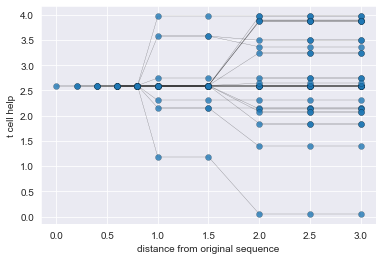

In [12]:
fig, axes = plt.subplots()
points = []
lines = []
for node in gc.tree.traverse():
    node_phenotype = getattr(node, "fitness")
    points.append((gc.tree.get_distance(node), node_phenotype))
    if node.up is not None:
        parent_phenotype = getattr(node.up, "fitness")
        lines.append(
            [
                (gc.tree.get_distance(node.up), parent_phenotype),
                (gc.tree.get_distance(node), node_phenotype),
            ]
        )
lc = mc.LineCollection(lines, colors="k", linewidths=0.3, alpha=0.5, zorder=3)
axes.add_collection(lc)
axes.scatter(
    *zip(*points), cmap=cmap, alpha=0.8, edgecolors="k", linewidths=0.2, zorder=4
)


axes.set_ylabel("t cell help")
axes.set_xlabel("distance from original sequence")